In [20]:
import json
import os
import cv2
import matplotlib.pyplot as plt

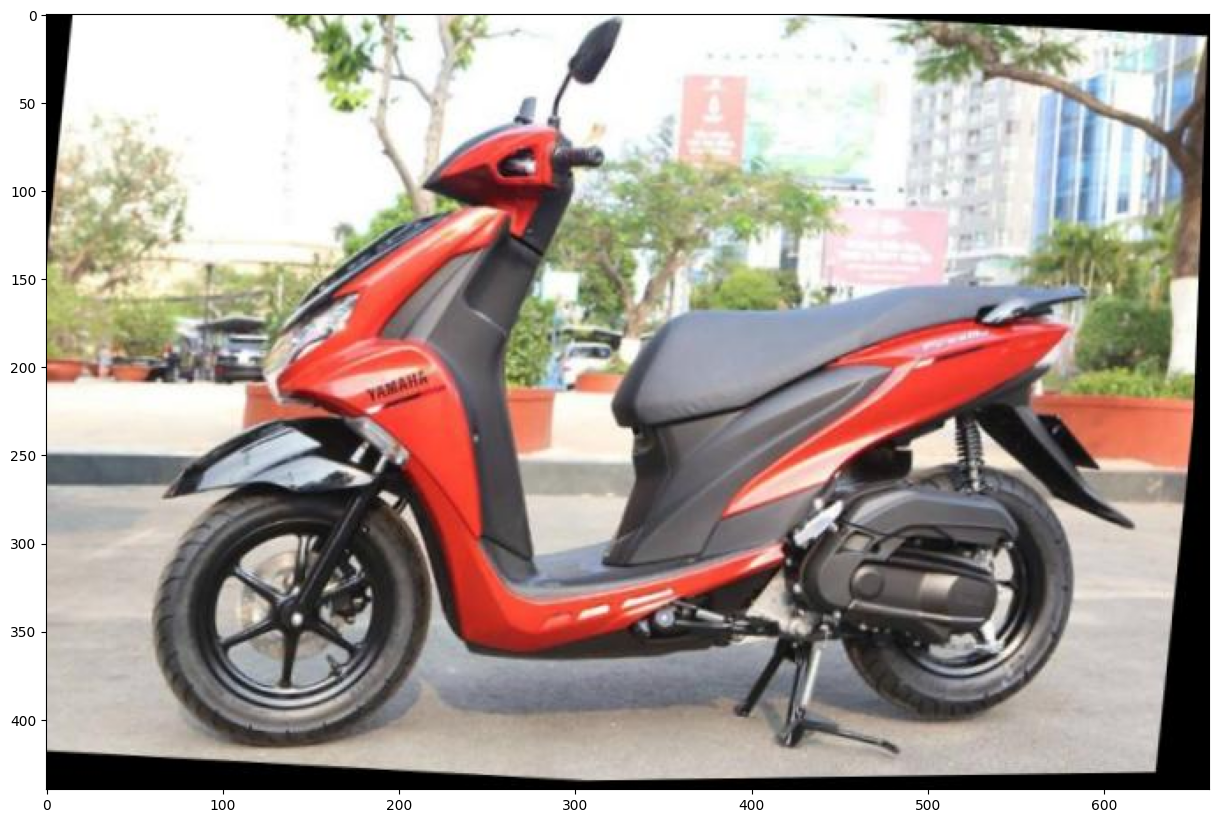

In [34]:
file_image_example = '../data/train/images/16_1554808647_858_nong_2019_yamaha_freego_ve_viet_nam_gia_tu_3299_trieu_dong_ya2_1554807803_width660height440_1568719059157_6926_jpg.rf.05e44c18bf57cb2cfd573ca2d5571ca5.jpg'

img = cv2.imread(file_image_example)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(img)

In [35]:
file_labels_example = '../data/train/labels/16_1554808647_858_nong_2019_yamaha_freego_ve_viet_nam_gia_tu_3299_trieu_dong_ya2_1554807803_width660height440_1568719059157_6926_jpg.rf.05e44c18bf57cb2cfd573ca2d5571ca5.txt'

with open(file_labels_example) as f:
    lines_txt = f.readlines()
    lines = []
    for line in lines_txt:
        lines.append([int(line.split()[0])] + [round(float(el), 7) for el in line.split()[1:]])

for idx, line in enumerate(lines):
    print("Rectangle {}:".format(idx+1), line)

FileNotFoundError: [Errno 2] No such file or directory: '../data/train/labels/1_1543625561_603_2019_kawasaki_ninja_250_sl_gia_60_trieu_dong_phai_manh_phan_khich_ka1_1543590588_width660height495_1568719111626_7656_jpg.rf.858decc5f3b5878c23aa56f28dfc2a94.txt'

In [22]:
keypoint_names = ['Head', 'Tail']

# Dictionary to convert rectangles classes into keypoint classes because keypoint classes should start with 0
rectangles2keypoints = {1:0, 2:1}

def converter(file_labels, file_image, keypoint_names):

    img = cv2.imread(file_image)
    img_w, img_h = img.shape[1], img.shape[0]
    
    with open(file_labels) as f:
        lines_txt = f.readlines()
        lines = []
        for line in lines_txt:
            lines.append([int(line.split()[0])] + [round(float(el), 5) for el in line.split()[1:]])

    bboxes = []
    keypoints = []

    # In this loop we convert normalized coordinates to absolute coordinates
    for line in lines:
        # Number 0 is a class of rectangles related to bounding boxes.
        if line[0] == 0:
            x_c, y_c, w, h = round(line[1] * img_w), round(line[2] * img_h), round(line[3] * img_w), round(line[4] * img_h)
            bboxes.append([round(x_c - w/2), round(y_c - h/2), round(x_c + w/2), round(y_c + h/2)])

        # Other numbers are the classes of rectangles related to keypoints.
        # After convertion, numbers of keypoint classes should start with 0, so we apply rectangles2keypoints dictionary to achieve that.
        # In our case:
        # 1 is rectangle for head keypoint, which is 0, so we convert 1 to 0;
        # 2 is rectangle for tail keypoint, which is 1, so we convert 2 to 1.
        if line[0] != 0:
            kp_id, x_c, y_c = rectangles2keypoints[line[0]], round(line[1] * img_w), round(line[2] * img_h)
            keypoints.append([kp_id, x_c, y_c])

    # In this loop we are iterating over each keypoint and looking to which bounding box it matches.
    # Thus, we are matching keypoints and corresponding bounding boxes.
    keypoints_sorted = [[[] for _ in keypoint_names] for _ in bboxes]
    for kp in keypoints:
        kp_id, kp_x, kp_y = kp[0], kp[1], kp[2]
        for bbox_idx, bbox in enumerate(bboxes):
            x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
            if x1 < kp_x < x2 and y1 < kp_y < y2:
                keypoints_sorted[bbox_idx][kp_id] = [kp_x, kp_y, 1] # All keypoints are visible
                
    return bboxes, keypoints_sorted

In [23]:
bboxes, keypoints_sorted = converter(file_labels_example, file_image_example, keypoint_names)

print("Bboxes:", bboxes)
print("Keypoints:", keypoints_sorted)

[ WARN:0@282120.836] global loadsave.cpp:241 findDecoder imread_('../data/train/images/1_1543625561_603_2019_kawasaki_ninja_250_sl_gia_60_trieu_dong_phai_manh_phan_khich_ka1_1543590588_width660height495_1568719111626_7656_jpg.rf.858decc5f3b5878c23aa56f28dfc2a94.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

TypeError: Image data of dtype object cannot be converted to float

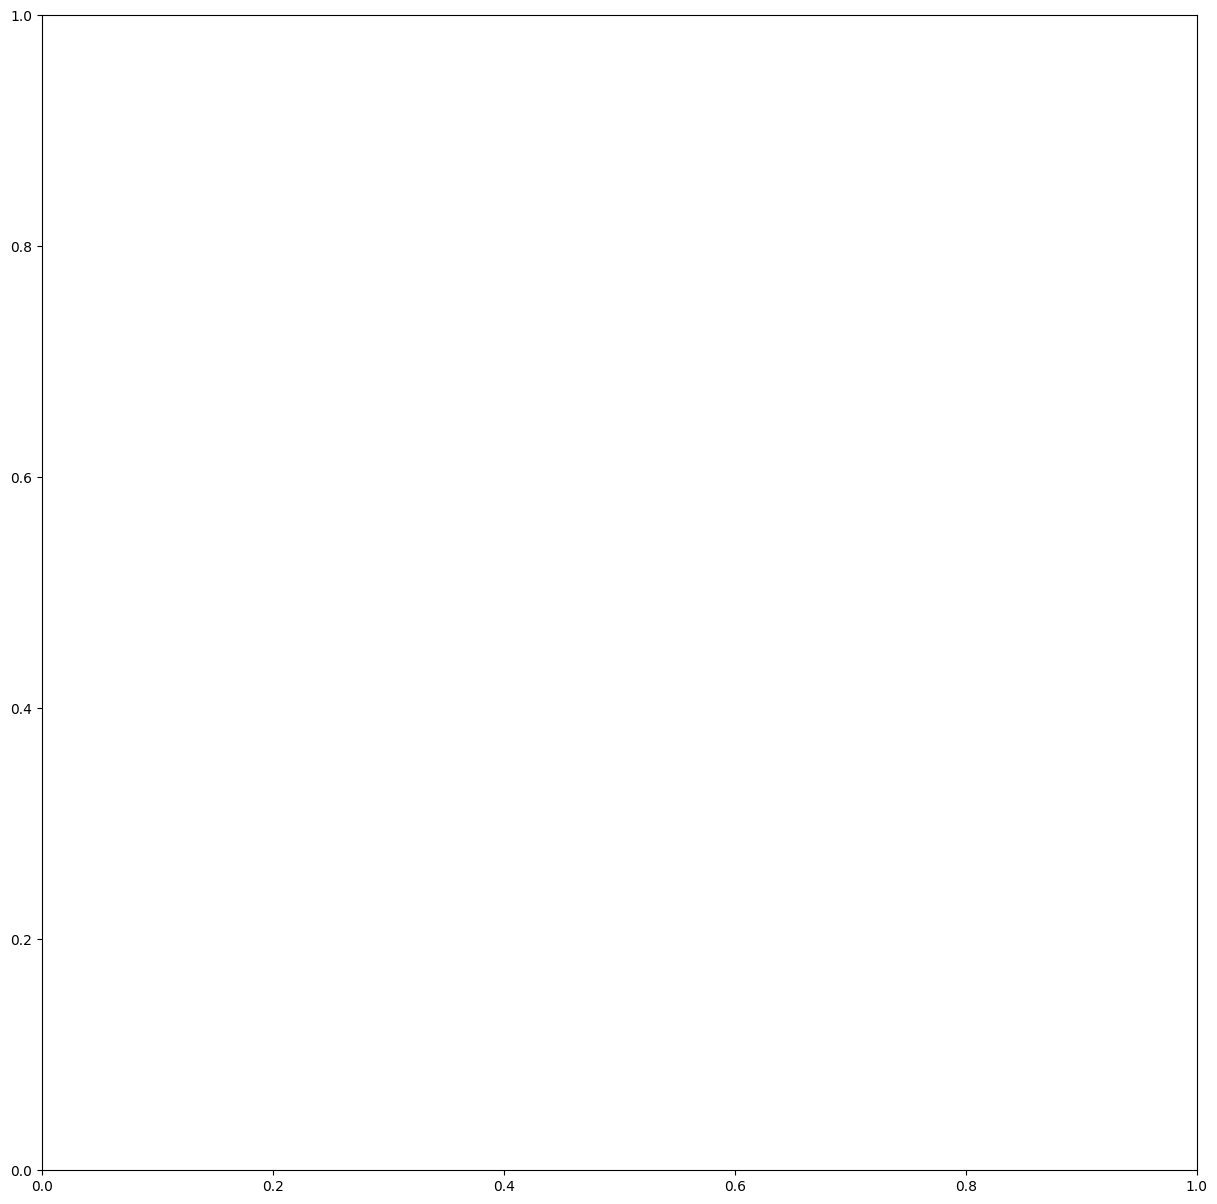

In [24]:
for bbox_idx, bbox in enumerate(bboxes):
    top_left_corner, bottom_right_corner = tuple([bbox[0], bbox[1]]), tuple([bbox[2], bbox[3]])
    img = cv2.rectangle(img, top_left_corner, bottom_right_corner, (0,255,0), 3)
    
    for kp_idx, kp in enumerate(keypoints_sorted[bbox_idx]):
        center = tuple([kp[0], kp[1]])
        img = cv2.circle(img, center, 5, (255,0,0), 5)
        img = cv2.putText(img, " " + keypoint_names[kp_idx], center, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), 4)
        
plt.figure(figsize=(15,15))
plt.imshow(img)

In [25]:
def dump2json(bboxes, keypoints_sorted, file_json):
    annotations = {}
    annotations['bboxes'], annotations['keypoints'] = bboxes, keypoints_sorted
    with open(file_json, "w") as f:
        json.dump(annotations, f)

In [26]:
IMAGES = '../data/test/images'
LABELS = '../data/test/labels'
ANNOTATIONS = '../data/test/annotations'

files_names = [file.split('.jpg')[0] for file in os.listdir(IMAGES)]

for file in files_names:
    file_labels = os.path.join(LABELS, file + ".txt")
    file_image = os.path.join(IMAGES, file + ".jpg")
    print("Processing", file_labels, file_image)
    if os.path.exists(file_labels):
        print("Processing", file_labels, file_image)
        bboxes, keypoints_sorted = converter(file_labels, file_image, keypoint_names)
        dump2json(bboxes, keypoints_sorted, os.path.join(ANNOTATIONS, file + '.json'))
    else:
        print(f"Label file not found for {file_image}, skipping.")

Processing ../data/test/labels/cw3rob_So_I_got_the_opportunity_to_test_a_790_adventure____9y6s6oddjzi31_1568720011613_20076_jpg.rf.280d5dc6c27628fa63c15ae5a242aa33.txt ../data/test/images/cw3rob_So_I_got_the_opportunity_to_test_a_790_adventure____9y6s6oddjzi31_1568720011613_20076_jpg.rf.280d5dc6c27628fa63c15ae5a242aa33.jpg
Processing ../data/test/labels/cw3rob_So_I_got_the_opportunity_to_test_a_790_adventure____9y6s6oddjzi31_1568720011613_20076_jpg.rf.280d5dc6c27628fa63c15ae5a242aa33.txt ../data/test/images/cw3rob_So_I_got_the_opportunity_to_test_a_790_adventure____9y6s6oddjzi31_1568720011613_20076_jpg.rf.280d5dc6c27628fa63c15ae5a242aa33.jpg


FileNotFoundError: [Errno 2] No such file or directory: '../data/test/annotations/cw3rob_So_I_got_the_opportunity_to_test_a_790_adventure____9y6s6oddjzi31_1568720011613_20076_jpg.rf.280d5dc6c27628fa63c15ae5a242aa33.json'